In [3]:

from inspire_dojson.api import marcxml2record


import gzip

import pymarc
# marcxml2record("str")

import xmltodict
import ujson;
import json;
import gzip

import xmltodict
import ujson;
import json;
import gzip
import importlib
importlib.reload(pymarc)




<module 'pymarc' from '/Users/filipi/Dropbox/Projects/InspireData/pymarc/pymarc/__init__.py'>

In [29]:

# with gzip.open("../Data/HEP-records.xml.gz","r") as fd:
#   data = ujson.loads(ujson.dumps(xmltodict.parse(fd.read())));

from pymarc import map_xml

# with gzip.open("../Data/HEP-records.xml.gz","r") as fd:
#   from pymarc import MARCReader
entry = None;
entries = [];
thefield = None
allKeys = {};
allKeysExample = {};
allKeysListCount = {};
with open("../Data/test.txt","w") as fout:
  with gzip.open("../Data/Experiments-records.xml.gz","r") as fd:
    def print_title(r):
      global entry,entries,fout,thefield,allKeys,allKeysExample,allKeysListCount
      entry = r;
      # print(r["961"].format_field())
      # fout.write(r.title()+"\n")
      keysSet = set();
      keysCount = {};
      keysContent = {};
      entryData = {};

      for field in r.fields:
        thefield = field;
        tag = field.tag;
        content = field.format_field();
        if(tag not in keysSet):
          keysSet.add(tag);
          keysCount[tag] = 0;
          keysContent[tag] = content;
        keysCount[tag] += 1;
  #           fout.write("\t%s: %s\n"%(tag,content));
        try:
          subfields = {};
          subfieldsLetter = {};
          if(len(field.subfields)>0):
            for subfieldIndex in range(0,len(field.subfields),2):
              subfieldName = field.subfields[subfieldIndex];
              subfieldValue = field.subfields[subfieldIndex+1];
              subTag = tag+"."+subfieldName;
              if(subTag not in keysSet):
                keysSet.add(subTag);
                keysCount[subTag] = 0;
                keysContent[subTag] = subfieldValue;
              keysCount[subTag] += 1;
              subfields[subTag] = subfieldValue;
              subfieldsLetter[subfieldName] = subfieldValue;
            if(tag in entryData):
              if(not isinstance(entryData[tag], list)):
                entryData[tag] = [entryData[tag]];
              entryData[tag].append(subfieldsLetter);
            else:
              entryData[tag] = subfieldsLetter;
  #               fout.write("\t\t%s: %s\n"%(subfieldName,subfieldValue));
        except AttributeError as error:
          pass
        
        if(len(subfields)==0):
          if(tag in entryData):
            if(not isinstance(entryData[tag], list)):
              entryData[tag] = [entryData[tag]];
            entryData[tag].append(content);
          else:
            entryData[tag] = content;
  #       fout.write("-----\n");

  #       fout.flush();
  #       entries.append(entry);
      for key in keysSet:
        if(key not in allKeys):
          allKeys[key] = 0;
          allKeysExample[key] = keysContent[key];
          allKeysListCount[key] = 0
        allKeysListCount[key] += keysCount[key];
        allKeys[key]+=1;
      processedEntry = processHEP(entryData);
#       processedEntry["raw"] = entryData;
      entries.append(processedEntry)
#       raise ValueError()
    map_xml(print_title, fd)




In [6]:
entry.subjects()[1].format_field()

'astro-ph'

In [8]:
def getTagSubtag(data,subtag,onErrorParent=True):
    if(isinstance(data,dict)):
      value = None
#       try: 
      if(subtag not in data):
        value = None;
      else:
        value = data[subtag];
#       except:
#         print((subtag,data));
#         raise error;
      return value;
    else:
      if(onErrorParent):
        return data;
      else:
        return None;

def getFirst(data,tag):
  value = None;
  if(tag in data):
    if(isinstance(data[tag],list)):
      value = data[tag][0];
    else:
      value = data[tag];
  return value;
  

def getAll(data,tag):
  value = [];
  if(tag in data):
    if(isinstance(data[tag],list)):
      value = data[tag];
    else:
      value = [data[tag]];
  return value;


def getEntry(data,tag,subtags=None,isList=False, onErrorParent=True):
  if(tag not in data):
    return None;
  if(subtags is not None):
    if(isList):
      dataList = getAll(data,tag);
      resultList = [];
      for dataValue in dataList:
        if(isinstance(subtags,dict)):
          resultEntry = {}
          for key in subtags:
            subTagResult = getTagSubtag(dataValue,subtags[key],onErrorParent);
            if(subTagResult):
              resultEntry[key] = subTagResult;
          resultList.append(resultEntry);
        else:
          subTagResult = getTagSubtag(dataValue,subtags,onErrorParent);
          if(subTagResult):
            resultList.append(subTagResult);
      return resultList
    else:
      dataValue = getFirst(data,tag);
      if(isinstance(subtags,dict)):
        resultEntry = {}
        for key in subtags:
          subTagResult = getTagSubtag(dataValue,subtags[key],onErrorParent);
          if(subTagResult):
            resultEntry[key] = subTagResult;
        return resultEntry;
      else:
        subTagResult = getTagSubtag(dataValue,subtags,onErrorParent);
        if(subTagResult):
          return subTagResult;
  else:
    if(isList):
      return getAll(data,tag);
    else:
      return getFirst(data,tag);

    

            


def processHEP(entryData):
  outData = {}
  
  propertyName = "ID"
  outData[propertyName] = getEntry(
    entryData,
    "001",
    subtags=None,
    isList=False,
    onErrorParent=True
  )
  
  propertyName = "DOI"
  outData[propertyName] = getEntry(
    entryData,
    "024",
    subtags={
      "Value": "a",
      "Type": "p",
    },
    isList=False,
    onErrorParent=False
  )
  
  propertyName = "Category"
  outData[propertyName] = getEntry(
    entryData,
    "037",
    subtags="c",
    isList=True,
    onErrorParent=False
  )
  
  propertyName = "FirstAuthor"
  outData[propertyName] = getEntry(
    entryData,
    "100",
    subtags={
      "ID": "x",
      "Name": "a",
      "Institution ID": "z",
      "ORCID": "k",
      "Email": "m",
    },
    isList=False,
    onErrorParent=False
  )
  
  propertyName = "Authors"
  outData[propertyName] = getEntry(
    entryData,
    "700",
    subtags={
      "ID": "x",
      "Name": "a",
      "Institution ID": "z",
      "ORCID": "k",
      "Email": "m",
    },
    isList=True,
    onErrorParent=False
  )
  
  propertyName = "Title"
  outData[propertyName] = getEntry(
    entryData,
    "245",
    subtags="a",
    isList=False,
    onErrorParent=True
  )
  
  propertyName = "PublicationDate"
  outData[propertyName] = getEntry(
    entryData,
    "260",
    subtags="c",
    isList=False,
    onErrorParent=True
  )

  propertyName = "PreprintDate"
  outData[propertyName] = getEntry(
    entryData,
    "269",
    subtags="c",
    isList=False,
    onErrorParent=True
  )
  
  propertyName = "NumberOfPages"
  outData[propertyName] = getEntry(
    entryData,
    "300",
    subtags="a",
    isList=False,
    onErrorParent=True
  )
  
  propertyName = "Degree"
  outData[propertyName] = getEntry(
    entryData,
    "500",
    subtags={
      "Type":"b",
      "Institution":"b",
      "Year":"d",
      "Institution ID":"z",
    },
    isList=False,
    onErrorParent=False
  )

#   propertyName = "Abstract"
#     outData[propertyName] = getEntry(
#       entryData,
#       "520",
#       subtags="a",
#       isList=False,
#       onErrorParent=True
#     )
    
  propertyName = "Classification"
  outData[propertyName] = getEntry(
    entryData,
    "650",
    subtags="a",
    isList=True,
    onErrorParent=False
  )
  
  propertyName = "Keywords"
  outData[propertyName] = getEntry(
    entryData,
    "653",
    subtags="a",
    isList=True,
    onErrorParent=True
  )
  
  propertyName = "Experiment"
  outData[propertyName] = getEntry(
    entryData,
    "693",
    subtags={
      "Experiment":"e",
      "Accelerator":"a",
      "Beam line":"b",
    },
    isList=True,
    onErrorParent=False
  )
  
  propertyName = "ControlledKeywords"
  outData[propertyName] = getEntry(
    entryData,
    "695",
    subtags="a",
    isList=True,
    onErrorParent=True
  )
  
  propertyName = "ControlledKeywords"
  outData[propertyName] = getEntry(
    entryData,
    "695",
    subtags="a",
    isList=True,
    onErrorParent=False
  )
  
  propertyName = "EnergyRange"
  outData[propertyName] = getEntry(
    entryData,
    "695",
    subtags="e",
    isList=True,
    onErrorParent=False
  )
  
  propertyName = "ThesisSupervisor"
  outData[propertyName] = getEntry(
    entryData,
    "701",
    subtags="a",
    isList=False,
    onErrorParent=True
  )
  
  propertyName = "Type"
  outData[propertyName] = getEntry(
    entryData,
    "980",
    subtags="a",
    isList=True,
    onErrorParent=True
  )
  
  propertyName = "References"
  outData[propertyName] = getEntry(
    entryData,
    "999",
    subtags={
      "ID": "0",
      "Journal ID": "1",
      "DOI": "a",
      "Year": "y",
      "Journal": "s",
    },
    isList=True,
    onErrorParent=False
  )
  
  
  propertyName = "PostDate"
  outData[propertyName] = getEntry(
    entryData,
    "961",
    subtags="x",
    isList=False,
    onErrorParent=False
  )
  
  
  propertyName = "LastDate"
  outData[propertyName] = getEntry(
    entryData,
    "961",
    subtags="c",
    isList=False,
    onErrorParent=False
  )
  
#   if("041" in entryData):
#     outData["Language"] = entryData["041"];

  
  return outData;


In [30]:
for key in sorted(allKeys.keys()):
  padding = ""
  if(key.find(".")>0):
    padding="    "
  isList = " "
  if(allKeysListCount[key]>allKeys[key]):
    isList = "*"
  if(allKeys[key]>=10):
    print("%s%s: %6d (%3.1f%%) %3.0f%s (%s)"%(padding,key,allKeys[key],allKeys[key]/allKeys["001"]*100,allKeysListCount[key]/allKeys[key],isList,allKeysExample[key] ))
    


001:   3646 (100.0%)   1  (1108188)
005:   3646 (100.0%)   1  (20170823152737.0)
046:   3316 (90.9%)   3* (2010)
    046.c:     14 (0.4%)   1  (2004)
    046.q:   2585 (70.9%)   1  (2010)
    046.r:   2113 (58.0%)   1* (2011-03-18)
    046.s:   1556 (42.7%)   1* (2014)
    046.t:   2245 (61.6%)   1* (9999)
    046.x:   1554 (42.6%)   1  (yes)
119:   3646 (100.0%)   1* (MAP NON Fermilab 902796)
    119.a:   3646 (100.0%)   1  (MAP)
    119.b:   3103 (85.1%)   1  (NON)
    119.c:    189 (5.2%)   1  (NEXT)
    119.d:    117 (3.2%)   1  (NEXT)
    119.u:   3085 (84.6%)   1* (Fermilab)
    119.z:   3082 (84.5%)   1* (902796)
245:   3588 (98.4%)   1  (Muon Accelerator Program)
    245.a:   3588 (98.4%)   1  (Muon Accelerator Program)
270:    782 (21.4%)   1* (cjhogan@fnal.gov)
    270.m:    782 (21.4%)   1* (cjhogan@fnal.gov)
372:   1471 (40.3%)   1* (INSPIRE 7.2)
    372.9:   1342 (36.8%)   1* (INSPIRE)
    372.a:   1471 (40.3%)   1* (7.2)
419:    781 (21.4%)   1* (GBAR)
    419.a:    780 (

In [19]:
entries[10000]

{'ID': '992423',
 'DOI': None,
 'Category': None,
 'FirstAuthor': {'Name': 'Rahman, Sabbir Ahmed'},
 'Authors': None,
 'Title': None,
 'PublicationDate': None,
 'PreprintDate': None,
 'NumberOfPages': None,
 'Degree': None,
 'Classification': None,
 'Keywords': None,
 'Experiment': None,
 'ControlledKeywords': None,
 'EnergyRange': None,
 'ThesisSupervisor': None,
 'Type': ['HEPNAMES'],
 'References': None,
 'PostDate': '1993-10-12',
 'LastDate': '2014-03-07'}

In [27]:
import re
years=[];
problematic = [];
for entry in entries:
  year = None;
  date = None
#   if("PostDate" in entry and entry["PostDate"] is not None):
#     date = entry["PostDate"]
#     match = re.match(r'.*([1-3][0-9]{3})', date)
#     if match is not None:
#       year = int(match.group(1));
  if (year is None):
    if("LastDate" in entry and entry["LastDate"] is not None):
      date = entry["LastDate"]
      match = re.match(r'.*([1-3][0-9]{3})', date)
      if match is not None:
        year = int(match.group(1));
  if(year is not None):
    years.append(year);
  else:
    problematic.append(date);
    
    

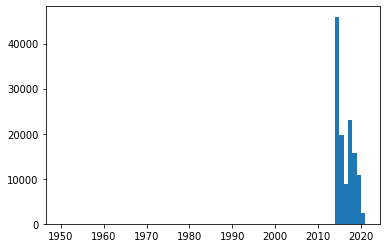

In [28]:
import matplotlib.pyplot as plt;
import numpy as np
plt.hist(years, bins=list(range(1950,2022)))
plt.show()